### Optimal control problem

We consider the following optimal control problem 

$$
    \left\{ \begin{array}{ll}
    \displaystyle \min_{x,u} \int_{t_0}^{t_f} x(t) ~\mathrm dt \\[1em]
    \text{s.c.}~\dot x(t) = u(t), & t\in [t_0, t_f]~\mathrm{a.e.}, \\[0.5em]
    \phantom{\mathrm{s.c.}~} u(t) \in [-1,1], & t\in [t_0, t_f], \\[0.5em]
    \phantom{\mathrm{s.c.}~} x(t_0) = x_0, \quad x(t_f) = x_f,
    \end{array} \right.
$$

with $x_0$, $t_0$, $x_f$ and $t_f$ fixed. This problem is simple, and can be analytically solve without the use of numerical method. However, the goal is to solve this problem by indirect shooting.  

### Indirect method

We introduce the pseudo-Hamiltonian 

$$
    h(x,p,p^0,u) = p^0 x + p u.
$$

For the sake of simplicity, we consider in this notebook only the normal case, and we fix $p^0 = -1$. According to the Pontryagin maximum principle, the maximizing control is given by $u(x,p) \to \mathrm{sign}(p)$. This function is non-differentiable, and may lead to numerical issues.  



Let us import the necessary package and define the studied optimal control problem with some fixed initial and final time and state values.

In [1]:
using Pkg
Pkg.activate(".")
using OptimalControl
using Plots
using ForwardDiff
using DifferentialEquations
using MINPACK

t0 = 0; x0 = 0; tf = 5; xf = 0          # initial and final time and state
@def ocp begin                          # problem definition

    t ∈ [ t0, tf ], time
    x ∈ R, state
    u ∈ R, control

    x(t0) == x0
    x(tf) == xf

    ẋ(t) == u(t)      

    ∫( x(t) ) → min

end

  Activating project at `c:\Users\uiv02757\OneDrive - Vitesco Technologies\git_repos\preconditioning\resources`


The (autonomous) optimal control problem is given by:

    t ∈ [t0, tf], time
    x ∈ R, state
    u ∈ R, control
    x(t0) == x0
    x(tf) == xf
    ẋ(t) == u(t)
    ∫(x(t)) → min

The (autonomous) optimal control problem is of the form:

    minimize  J(x, u) = ∫ f⁰(x(t), u(t)) dt, over [0, 5]

    subject to

        ẋ(t) = f(x(t), u(t)), t in [0, 5] a.e.,

        ϕl ≤ ϕ(x(0), x(5)) ≤ ϕu, 

    where x(t) ∈ R and u(t) ∈ R.

Declarations (* required):
╭────────┬────────┬──────────┬──────────┬───────────┬────────────┬─────────────╮
│ times* │ state* │ control* │ variable │ dynamics* │ objective* │ constraints │
├────────┼────────┼──────────┼──────────┼───────────┼────────────┼─────────────┤
│   V    │   V    │    V     │    X     │     V     │     V      │      V      │
╰────────┴────────┴──────────┴──────────┴───────────┴────────────┴─────────────╯


Thanks to the control-toolbox, the flow $\varphi$ of the (true) Hamiltonian

$$
    H(x,p) = h(x,p,-1, u(x,p)) = p^0 x + \lvert p \rvert 
$$

 is given by the function $\texttt{Flow}$. The shooting function $S \colon \mathbb{R} \to \mathbb{R}$ is defined by

 $$
    S(p_0) = \pi \big( \varphi(t_0, x_0, p_0, t_f) \big) - x_f
 $$ 

 where $\pi (x,p) = x$ is the classical $x$-space projection.


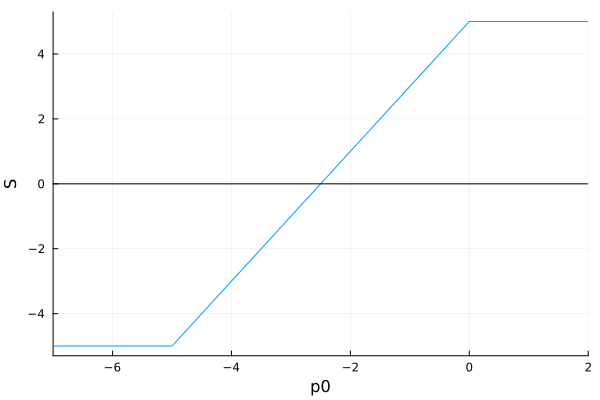

In [2]:
ϕ = Flow(ocp, (x,p) -> sign(p))             # flow with maximizing control 
π((x,p)) = x;                               # projection on state space

S(p0) = π( ϕ(t0, x0, p0, tf) ) - xf;        # shooting function
nle = p0 -> [S(p0[1])]                      # intermediate function

# Plot
plot(range(-7, 2, 500), S, xlim = [-7, 2])
plot!([-7,2], [0,0], color = :black)
plot!(xlabel = "p0", ylabel = "S", legend=false)

The main goal now is to find the zero of $S$. To this purpose, we use the numerical solver $\texttt{hybrd1}$ given in the package $\texttt{MINPACK.jl}$. If we don't provide the Jacobian $J_S$ of $S$ to the solver, the finite difference method is used to approximate it. 


Iter     f(x) inf-norm    Step 2-norm      Step time
------   --------------   --------------   --------------
     1     3.000000e+00     0.000000e+00         0.138000
     2     9.318967e-01     1.069263e+00         0.191000
     3     3.908179e-08     2.171079e-01         0.002000
     4     3.126006e-08     3.818465e-16         0.001000
     5     2.602624e-08     7.541206e-17         0.001000
     6     1.122729e-07     1.864781e-15         0.000000
     7     1.251064e-08     1.228963e-15         0.001000
     8     1.071865e-08     6.960129e-18         0.001000
     9     3.372047e-08     2.490162e-16         0.001000
    10     6.149611e-09     1.433785e-16         0.001000
    11     2.836331e-08     2.624355e-17         0.000000
    12     2.550366e-08     1.772446e-17         0.001000
    13     2.794534e-08     1.292187e-17         0.001000
    14     2.543587e-08     1.364932e-17         0.002000
    15     6.042093e-09     4.286522e-19         0.021000
    16     3.036848

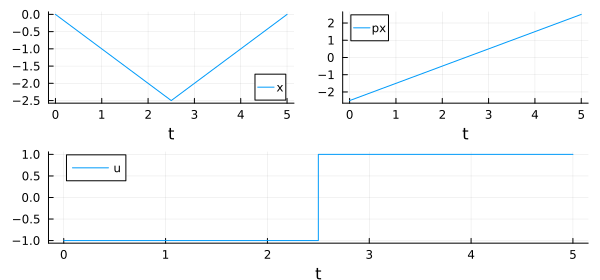

In [3]:
# finite difference method
ξ = [-1.0]                                          # initial guess
S!(s, ξ) = (s[:] .= S(ξ[1]); nothing)               # intermediate function
p0_sol = fsolve(S!, ξ, show_trace = true)           # solve
println(p0_sol)
sol = ϕ((t0, tf), x0, p0_sol.x)                     # get the optimal trajectory
plot(sol)                                           # plot

Now, we want to provide $J_S$ to the solver, thanks to the $\texttt{ForwardDiff.jl}$ package. This Jacobian is computed with the variational equation, and leads to a false result in our case.

Details.

Denoting $z = (x,p)$, we have 

$$
    \varphi(t_0, z_0, t_f) = z_0 + \int_{t_0}^{t_f} \vec H\big(\varphi(t_0, z_0, t)\big) \,\mathrm dt. 
$$

If we assume that $z_0 \to \varphi(t_0, z_0, t_f)$ is differentiable, we have  

$$
    \frac{\partial \varphi}{\partial z_0}(t_0, z_0, t_f)\cdot \delta z_0 =  \delta z_0 + \int_{t_0}^{t_f} \vec H'\big(\varphi(t_0, z_0, t)\big)\cdot \left( \frac{\partial \varphi}{\partial z_0}(t_0, z_0, t) \cdot \delta z_0 \right) \,\mathrm dt, 
$$

and so, $z_0 \to \frac{\partial \varphi}{\partial z_0}(t_0, z_0, t_f)\cdot \delta z_0$ is solution of the variational equations

$$
    \frac{\partial \delta z}{\partial t}(t) = \vec H'\big(\varphi(t_0, z_0, t_f)\big) \cdot \delta z(t), \qquad \delta z(t_0) = \delta z_0.
$$

In the studied optimal control problem, we have 

$$
    \vec H(x,p) = (\mathrm{sign}(p), -1) 
$$

and so, we have $\vec H'(z) = 0_2$ almost everywhere, which implies


$$
    \frac{\partial \varphi}{\partial z_0}(t_0, z_0, t_f) \cdot \delta z_0 = \mathrm{exp}\big((t_f-t_0) 0_2 \big)\cdot \delta z_0 = \delta z_0.
$$ 

The Jacobian of the shooting function is then given by 

$$
    S'(p_0) = \pi \left( \frac{\partial \varphi}{\partial p_0}(t_0, x_0, p_0, t_f) \right) = \pi \left( \frac{\partial \varphi}{\partial z_0}(t_0, z_0, t_f) \cdot (0,1) \right) = \pi(0,1) = 0. 
$$

In [4]:
# auto-differentiation : ForwardDiff 
ξ = [-1.0]                                          # initial guess
JS(ξ) = ForwardDiff.jacobian(p -> [S(p[1])], ξ)     # compute jacobian by forward differentiation
println("ξ = ", ξ[1])
println("JS(ξ) : ", JS(ξ)[1])

ξ = -1.0
JS(ξ) : 0.0


However, the solver $\texttt{hybrd1}$ uses rank 1 approximation to actualize the Jacobian insted of compute it at each iteration, which imply that it still converges to the solution even if the given Jacobian is completely false.

Iter     f(x) inf-norm    Step 2-norm      Step time
------   --------------   --------------   --------------
     1     3.000000e+00     0.000000e+00         0.006000
     2     5.000000e+00     1.000000e+04         0.040000
     3     5.000000e+00     3.906250e+03         0.000000
     4     5.000000e+00     3.906250e+03         0.001000
     5     5.000000e+00     3.906250e+03         0.000000
     6     5.000000e+00     5.493164e+02         0.000000
     7     5.000000e+00     7.724762e+01         0.000000
     8     9.550781e-01     1.086295e+01         0.000000
     9     2.633355e-08     2.280435e-01         0.002000
    10     4.034347e-08     1.733639e-16         0.001000
    11     7.549755e-09     6.346772e-17         0.000000
Results of Nonlinear Solver Algorithm
 * Algorithm: Modified Powell (User Jac, Expert)
 * Starting Point: [-1.0]
 * Zero: [-2.500000011044682]
 * Inf-norm of residuals: 0.000000
 * Convergence: true
 * Message: algorithm estimates that the relative er

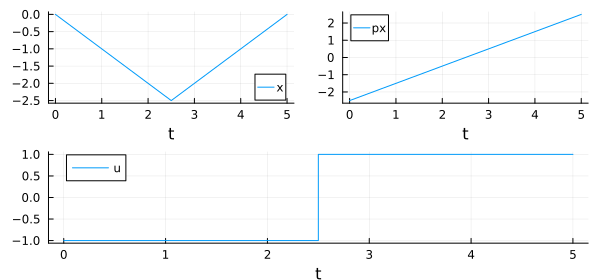

In [5]:
JS!(js, ξ) = (js[:] .= JS(ξ); nothing)          # intermediate function
p0_sol = fsolve(S!, JS!, ξ, show_trace = true)  # solve
println(p0_sol)
sol = ϕ((t0, tf), x0, p0_sol.x)                 # get the optimal trajectory
plt = plot(sol)                                 # plot

The goal is to provide the true Jacobian of $S$ by using the $\texttt{ForwardDiff}$ package, and so we need to indicate to the solver that the dynamic of the system change when $p = 0$.

To understang why we need to give this information to the solver, see the following details. 

Details. 

The problem is that the Hamiltonian $H$ is not differentiable everywhere due to the maximizing control. This control is bang-bang ($u = 1$ and $u = -1$). 
 
Let now construct the two smooth Hamiltonians associated to these two controls 

$$
    H^+(x,p) = h(x,p,-1,1) = -x + p \qquad \text{and} \qquad H^-(x,p) = h(x,p,-1,-1) =  -x - p. 
$$

Their associated vector fields are given by 

$$
    \vec H^+(x,p) = (1,1) \qquad \text{and} \qquad \vec H^-(x,p) = (-1, 1), 
$$

and their associated flow correspond to 

$$
    \varphi^+(t_0, z_0, t_f) = z_0 + \left( \begin{array}{c} 1 \\ 1 \end{array} \right) (t_f -t_0)
    \qquad \text{and} \qquad 
    \varphi^-(t_0, z_0, t_f) = z_0 + \left( \begin{array}{c} -1 \\ \phantom{-} 1 \end{array} \right) (t_f -t_0).
$$

If we assume that the optimal structure of the problem is negative then positive bangs, then the associated flow is defined by  

$$ 
    \varphi(t_0, z_0, t_f) = \varphi^+ \big( t_1(z_0), \varphi^-\big(t_0, z_0, t_1(z_0)\big), t_f \big),
$$

with the following condition 

$$
    \pi_p \big( \varphi^-(t_0, z_0, t_1(z_0)) \big) = 0,
$$

where $\pi_p(x,p) = p$ is the classical $p$-space projection. By devlopping this last condition, an explicit form of the function $t_1(\cdot)$ is given by 

$$
    t_1(x_0, p_0) = t_0 - p_0.
$$

Finally, we have 

$$
    \begin{align*}
    \frac{\partial \varphi}{\partial z_0} 
    &= \frac{\partial \varphi^+}{\partial t_0} \frac{\partial t_1}{\partial z_0} + \frac{\varphi^+}{\partial z_0} \left( \frac{\partial \varphi^-}{\partial z_0} + \frac{\partial \varphi^-}{\partial t_f} \frac{\partial t_1}{\partial z_0} \right) \\
    &= \left( \begin{array}{c} -1 \\ -1 \end{array} \right) \left( \begin{array}{cc}0 & -1 \end{array} \right) + \left( \begin{array}{cc} 1 & 0 \\ 0 & 1 \end{array} \right) \left[
    \left( \begin{array}{cc} 1 & 0 \\ 0 & 1 \end{array} \right) + \left( \begin{array}{c} -1 \\ \phantom - 1 \end{array} \right) \left( \begin{array}{cc}0 & -1 \end{array} \right)
    \right] \\
    &= \left( \begin{array}{cc} 0 & 1 \\ 0 & 1 \end{array} \right) + \left( \begin{array}{cc} 1 & 0 \\ 0 & 1 \end{array} \right) + \left( \begin{array}{cc} 0 & \phantom -1 \\ 0 & -1 \end{array} \right) \\ 
    &= \left( \begin{array}{cc} 1 & 2 \\ 0 & 1 \end{array} \right)
    \end{align*}
$$

and so, we have that 

$$
    S'(p_0) = \pi \left( \frac{\partial \varphi}{\partial p_0}(t_0, x_0, p_0, t_f) \right) = \pi \left( \frac{\partial \varphi}{\partial z_0}(t_0, z_0, t_f) \cdot (0,1) \right) = \pi(2,1) = 2.
$$

End of details

To provide this change of dynamic to the solver, we need to use a callback during the integration that will execute the function $\texttt{affect!}$ when $\texttt{condition(x,p)} = 0$.

For us, the condition is given by $(x,p) \to p$. For the $\texttt{affect!}$ function, we use a global parameter $\alpha$. This parameter will be set to $\pm 1$ at the beginning of the integration and it sign will change with the $\texttt{affect!}$ function. 

Thanks to the $\texttt{control-toolbox}$ package, the created callback can be easily pass to the integrator throught the $\texttt{Flow}$ function.

ξ = -1.0
JS(ξ) : 2.0000000000000018
Iter     f(x) inf-norm    Step 2-norm      Step time
------   --------------   --------------   --------------
     1     3.000000e+00     0.000000e+00         0.346000
     2     6.994405e-15     2.250000e+00         0.007000
     3     4.551914e-15     1.262177e-29         0.000000
     4     3.441691e-15     1.774937e-30         0.001000
     5     2.775558e-15     1.972152e-31         0.001000
     6     3.441691e-15     1.972152e-31         0.000000
     7     2.775558e-15     1.972152e-31         0.000000
     8     2.997602e-15     1.774937e-30         0.002000
     9     1.443290e-15     1.972152e-31         0.000000
    10     2.997602e-15     7.888609e-31         0.000000
    11     2.997602e-15     1.972152e-31         0.000000
    12     2.997602e-15     1.972152e-31         0.000000
    13     2.997602e-15     1.972152e-31         0.000000
    14     1.443290e-15     1.972152e-31         0.000000
    15     2.343750e-02     1.373291e-04 

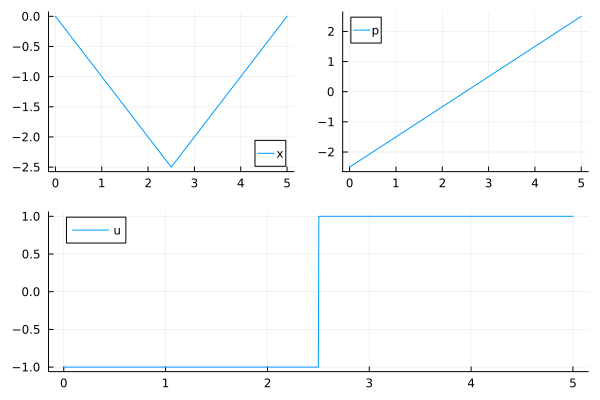

In [7]:
global α                                                    # parameter: ̇p(t) = α with α = ±1

function condition(z, t, integrator)                        # event when condition(x,p) == 0
    x,p = z
    return p
end

function affect!(integrator)                                # action when condition == 0 
    global α = -α
    nothing
end

cb = ContinuousCallback(condition, affect!)                 # callback 

φ_ = Flow(ocp, (x,p) -> α, callback = cb)                   # intermediate flow

function φ(t0, x0, p0, tf; kwargs...)                       # flow
    global α = sign(p0)
    return φ_(t0, x0, p0, tf; kwargs...)
end

function φ((t0, tf), x0, p0; kwargs...)                     # flow for plot
    global α = sign(p0)
    return φ_((t0, tf), x0, p0; kwargs...)
end

Shoot(p0) = π( φ(t0, x0, p0, tf) ) - xf                     # shooting function

ξ = [-1.0]                                                  # initial guess
JShoot(ξ) = ForwardDiff.jacobian(p -> [Shoot(p[1])], ξ)     # compute jacobian by forward differentiation
println("ξ = ", ξ[1])
println("JS(ξ) : ", JShoot(ξ)[1])
Shoot!(shoot, ξ) = (shoot[:] .= Shoot(ξ[1]); nothing)       # intermediate function
JShoot!(jshoot, ξ) = (jshoot[:] .= JShoot(ξ); nothing)      # intermediate function

p0_sol = fsolve(Shoot!, JShoot!, ξ, show_trace = true)      # solve
println(p0_sol)
sol_ = φ((t0, tf), x0, p0_sol.x[1], saveat=range(t0, tf, 500))  # get optimal trajectory

# plot
sol = OptimalControl.OptimalControlSolution(sol_)
t = sol.times
x = sol.state
p = sol.costate
u = sign ∘ p

plt_x = plot(t, x, label = "x")
plt_p = plot(t, p, label = "p")
plt_u = plot(t, u, label = "u")

plt_xp = plot(plt_x, plt_p, layout=(1, 2))
plot(plt_xp, plt_u, layout = (2, 1))
